# Transfer Learning for Flower Classification

We use transfer learning applied to MobileNetV2, start by unfreezing 5 layers and then try and do more.

In [1]:
import tarfile
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from google.colab import drive
from google.colab import files
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import layers, models

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

In [2]:
# Set seeds for reproducibility
keras.utils.set_random_seed(1)

# Data fetching

Import the data and apply normalization/augmentation/division in train, validation and test set.

In [3]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['roses', 'tulips', 'daisy', 'dandelion', 'sunflowers']


In [5]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
# Normalize data first:

X_normalized = X/255.
print(X_normalized.shape)
del(X)

(3670, 224, 224, 3)


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [8]:
# Delete unused data, to prevent RAM from going boom

del(X_normalized)

In [9]:
# Sequence of modules to place before the actual NN

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [10]:
# Encode classes in valid format

y_train_encoded = to_categorical(y_train, 5)
y_val_encoded = to_categorical(y_val, 5)

# Train the NN with frozen layers

FWe do this for reference:

In [11]:
# Load and freeze pretrained model
pretrained_layer = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
pretrained_layer.trainable = False

# Add custom layers
pretrained_model_aug = keras.Sequential([
    data_augmentation,
    pretrained_layer,
    layers.Flatten(),
    layers.Dense(5, activation='softmax')
])

# Compile the model
pretrained_model_aug.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

patience_freeze = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_freeze, restore_best_weights=True)

In [12]:
pretrained_layer.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [13]:
pretrained_model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 5)                 313605    
                                                                 
Total params: 2571589 (9.81 MB)
Trainable params: 313605 (1.20 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [14]:
# Fit model with callbacks
history = pretrained_model_aug.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
92/92 [==============================] - 13s 89ms/step - loss: 2.8238 - accuracy: 0.7411 - val_loss: 1.4499 - val_accuracy: 0.8283
Epoch 2/30
92/92 [==============================] - 5s 52ms/step - loss: 2.2134 - accuracy: 0.8106 - val_loss: 3.5196 - val_accuracy: 0.7738
Epoch 3/30
92/92 [==============================] - 5s 52ms/step - loss: 1.8009 - accuracy: 0.8569 - val_loss: 2.2817 - val_accuracy: 0.8174
Epoch 4/30
92/92 [==============================] - 5s 58ms/step - loss: 1.5660 - accuracy: 0.8726 - val_loss: 2.2240 - val_accuracy: 0.8311
Epoch 5/30
92/92 [==============================] - 5s 54ms/step - loss: 1.3802 - accuracy: 0.8954 - val_loss: 2.6153 - val_accuracy: 0.8202
Epoch 6/30
92/92 [==============================] - 5s 56ms/step - loss: 1.3848 - accuracy: 0.8975 - val_loss: 2.6947 - val_accuracy: 0.8392


## Results

In [15]:
# Load history dict
history_dict = history.history

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history_dict)

# Add an epoch column
history_df['epoch'] = history_df.index + 1

In [16]:
y_pred = pretrained_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

12/12 [==============================] - 1s 41ms/step


In [17]:
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute F1 scores for each class
f1_scores = f1_score(y_test, y_pred_classes, average=None)
mean_f1_score = np.mean(f1_scores)

# Print F1 scores
print("F1 Scores for each class:")
for i, score in enumerate(f1_scores):
    print(f"Class {i}: {score:.2f}")

# Print mean F1 score
print(f"Mean F1 Score: {mean_f1_score:.4f}")

Accuracy: 82.29%
F1 Scores for each class:
Class 0: 0.77
Class 1: 0.79
Class 2: 0.83
Class 3: 0.85
Class 4: 0.87
Mean F1 Score: 0.8222


In [18]:
# Save the model to Google Drive
# drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_transfer_learning.keras'
pretrained_model_aug.save(model_save_path)

# Train the NN unfreezing top layers

In [19]:
len(pretrained_layer.layers)

154

In [20]:
pretrained_layer.trainable = True

# Fine-tune from this layer onwards
fine_tuning = len(pretrained_layer.layers) - 5

# Freeze all the layers before fine_tuned_ind
for layer in pretrained_layer.layers[:fine_tuning]:
    layer.trainable =  False

In [21]:
for layer in pretrained_layer.layers[-fine_tuning:]:
  print(layer)

In [22]:
# set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00001)

# Recompile the model with a lower learning rate for fine-tuning
pretrained_model_aug.compile(
    optimizer=Adam(learning_rate=1e-4),  # 1/100 original LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = pretrained_model_aug.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
92/92 [==============================] - 12s 71ms/step - loss: 1.2715 - accuracy: 0.8484 - val_loss: 3.5381 - val_accuracy: 0.7520 - lr: 1.0000e-04
Epoch 2/30
92/92 [==============================] - 5s 58ms/step - loss: 0.7637 - accuracy: 0.8845 - val_loss: 5.5192 - val_accuracy: 0.7030 - lr: 1.0000e-04
Epoch 3/30
92/92 [==============================] - 5s 53ms/step - loss: 0.5703 - accuracy: 0.9026 - val_loss: 6.1311 - val_accuracy: 0.7057 - lr: 1.0000e-04
Epoch 4/30
91/92 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.9056
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
92/92 [==============================] - 6s 64ms/step - loss: 0.4505 - accuracy: 0.9057 - val_loss: 4.9365 - val_accuracy: 0.7193 - lr: 1.0000e-04
Epoch 5/30
92/92 [==============================] - 6s 67ms/step - loss: 0.2657 - accuracy: 0.9312 - val_loss: 4.0062 - val_accuracy: 0.7411 - lr: 7.0000e-05
Epoch 6/30
92/92 [==============================] 

## Results

In [23]:
# Assuming you have the history dictionary loaded
history_dict_fine = history_finetune.history

# Create a DataFrame from the history dictionary
history_df_fine = pd.DataFrame(history_dict_fine)

# Add an epoch column
history_df_fine['epoch'] = history_df_fine.index + 1

In [24]:
y_pred1 = pretrained_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes1 = np.argmax(y_pred1, axis=1)

12/12 [==============================] - 2s 45ms/step


In [25]:
accuracy1 = accuracy_score(y_test, y_pred_classes1)
print(f'Accuracy: {accuracy1 * 100:.2f}%')

# Compute F1 scores for each class
f1_scores1 = f1_score(y_test, y_pred_classes1, average=None)
mean_f1_score1 = np.mean(f1_scores1)

# Print F1 scores
print("F1 Scores for each class:")
for i, score in enumerate(f1_scores1):
    print(f"Class {i}: {score:.2f}")

# Print mean F1 score
print(f"Mean F1 Score: {mean_f1_score1:.4f}")

Accuracy: 92.10%
F1 Scores for each class:
Class 0: 0.92
Class 1: 0.90
Class 2: 0.89
Class 3: 0.93
Class 4: 0.96
Mean F1 Score: 0.9197


# Make final plot of results

In [26]:
epochs_0 = len(history.history['accuracy'])-patience_freeze+1

def plot_history_fined(history, history_finetune, initial_epochs=epochs_0, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """

    acc = history.history['accuracy'][:epochs_0]
    acc += history_finetune.history['accuracy']
    val_acc = history.history['val_accuracy'][:epochs_0]
    val_acc += history_finetune.history['val_accuracy']

    loss = history.history['loss'][:epochs_0]
    loss += history_finetune.history['loss']
    val_loss = history.history['val_loss'][:epochs_0]
    val_loss += history_finetune.history['val_loss']


    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 6))
    ax1.plot(acc, label='Training', marker='o', ls='-')
    ax1.plot(val_acc, label='Validation', marker='o', ls='-')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', xlabel='epochs', title='Training - Validation Accuracy',
            ylim=([0.6,1.005]))
    ax1.grid(True, alpha=0.4)

    ax2.plot(loss, label='Training', marker='o', ls='-')
    ax2.plot(val_loss, label='Validation', marker='o', ls='-')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [-0.5,7] , label='Fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([-0.5, 7])) #
    ax2.grid(True, alpha=0.4)

    #plt.savefig("finetuned_result.png")
    #files.download("finetuned_result.png")
    plt.show()

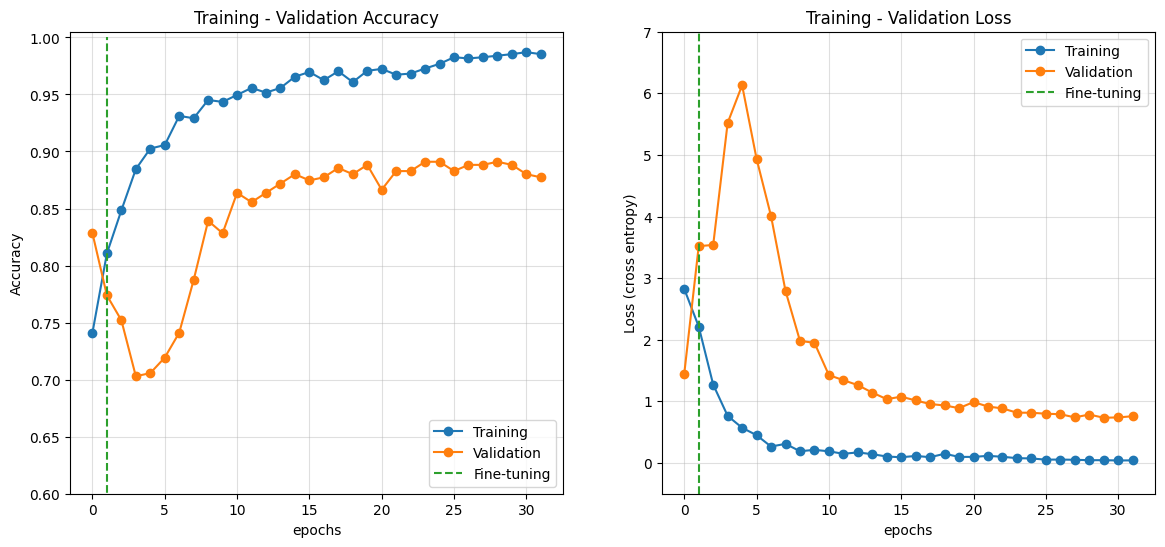

In [27]:
plot_history_fined(history, history_finetune)